# HDspace classification (MLP with feature selection)

In [1]:
import sys
import os
import mxnet as mx
import numpy as np
import pandas as pd
import data
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging
import sklearn
from sklearn.manifold import TSNE
from utilities import *
try:
   import cPickle as pickle
except:
   import pickle
import gzip

# for visualization
from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Process feature selection of optimal subset

In [2]:
NME_nxgraphs = r'Z:\Cristina\Section3\paper_notes_section3_MODIFIED\datasets'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load discrall_dict dict for all lesions
discrall_dict_allNMEs =   pd.read_csv(os.path.join(NME_nxgraphs, "named_nxGnormfeatures_allNMEs_descStats.csv"), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)


## load RFE optimal subset and use only these features in the analysis

In [3]:
optimalFeatureSet = pd.read_csv(os.path.join(NME_nxgraphs,'optimalFeatureSet.csv'), index_col=0)

# fnames, ftypes
ftype_dyn = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "dynamic")]
print(ftype_dyn)
# select 9 columns
selNMEs_dynamic = allNMEs_dynamic[ftype_dyn['fnames']]  

ftype_morp = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "morphology")]
print(ftype_morp)
# select 8 columns
selNMEs_morphology = allNMEs_morphology[ftype_morp['fnames']]  

ftype_text = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "texture")]
print(ftype_text)
# select 30 columns
selNMEs_texture = allNMEs_texture[ftype_text['fnames']]  

ftype_stage1 = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "stage1")]
print(ftype_stage1)
# select 29 columns
selNMEs_stage1 = allNMEs_stage1[ftype_stage1['fnames']]  

ftype_nxG = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "NetworkConnectivity")]
print(ftype_nxG)
# select 34 columns
seldiscrall_dict_allNMEs = discrall_dict_allNMEs[ftype_nxG['fnames']]  



               fnames   ftypes
4          SER_inside  dynamic
6       alpha_countor  dynamic
7        alpha_inside  dynamic
8         SER_countor  dynamic
11  Vr_post_1_countor  dynamic
17   Slope_ini_inside  dynamic
20  Slope_ini_countor  dynamic
56          A_countor  dynamic
97       beta_countor  dynamic
                    fnames      ftypes
3           edge_sharp_std  morphology
10               max_F_r_i  morphology
14            irregularity  morphology
15               var_F_r_i  morphology
32              ivVariance  morphology
41              mean_F_r_i  morphology
43             circularity  morphology
68  iiiMax_Margin_Gradient  morphology
                                     fnames   ftypes
1          texture_sumvariance_nondir_post1  texture
2             texture_variance_nondir_post1  texture
5         texture_diffvariance_nondir_post1  texture
12         texture_sumvariance_nondir_post2  texture
13          texture_sumentropy_nondir_post2  texture
16          texture_s

In [4]:
#########  
nxGdiscfeatures = seldiscrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(selNMEs_dynamic.shape[0], selNMEs_dynamic.shape[1]))
normdynamic = (selNMEs_dynamic - selNMEs_dynamic.mean(axis=0)) / selNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(selNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (selNMEs_morphology - selNMEs_morphology.mean(axis=0)) / selNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(selNMEs_texture.shape[0], selNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / selNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (selNMEs_texture - selNMEs_texture.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} Optimal Subset of NME features of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

#########
# define variables for classifier
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001

Loading 792 leasions with nxGdiscfeatures of size = 34
Normalizing dynamic 792 leasions with features of size = 9
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 30
Normalizing stage1 792 leasions with features of size = 100
Loading 792 Optimal Subset of NME features of size = 225
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


## MLP as classifier (experiment modified #1 or Baseline)


In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import interp
from itertools import cycle

# unbiased validation with held-out set
sep = int(combX_allNME.shape[0]*0.10)
X_val = combX_allNME[:sep]
y_val = roi_labels[:sep]
y_val = (np.asarray(y_val)=='M').astype(int)

X_train = combX_allNME[sep:]
y_train = roi_labels[sep:]

# Classification and ROC analysis
datalabels = np.asarray(y_train)
dataspace = X_train
# ignore unlabeled cases, supervised learning only relies on labels
X = dataspace[datalabels!='K',:]
y = np.asarray(datalabels[datalabels!='K']=='M').astype(int)

#####################
# MLP fully coneected networks for classification
#####################
batch_size = 50
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, random_state=33)
# Evaluate a score by cross-validation           
tprs_train = []; auc_train = []
tprs_val = []; auc_val = []
mean_fpr_OrigX = np.linspace(0, 1, 100)
cvi = 0
## to append pooled predictions
pooled_pred_train = pd.DataFrame()
pooled_pred_val = pd.DataFrame()
for train, test in cv.split(X, y):
    # Multilayer Perceptron
    MLP_train_iter = mx.io.NDArrayIter(X[train], y[train], batch_size, shuffle=False)
    MLP_val_iter = mx.io.NDArrayIter(X[test], y[test], batch_size)    
    
    # We’ll define the MLP using MXNet’s symbolic interface
    dataMLP = mx.sym.Variable('data')
    
    #The following code declares two fully connected layers with 128 and 64 neurons each. 
    #Furthermore, these FC layers are sandwiched between ReLU activation layers each 
    #one responsible for performing an element-wise ReLU transformation on the FC layer output.
    # The first fully-connected layer and the corresponding activation function
    fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
    act1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
    act2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    # data has 2 classes
    fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
    # Softmax with cross entropy loss
    mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
    
    # create a trainable module on CPU                   
    mon = mx.mon.Monitor(interval=100, pattern='.*', sort=True); # Defaults to mean absolute value |x|/size(x)
    #checkpoint = mx.callback.do_checkpoint('mlp_model_params_z{}_mu{}.arg'.format(self.best_args['znum'],self.best_args['num_centers']))
    mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
    mlp_model.fit(MLP_train_iter,  # train data
                  optimizer='sgd',  # use SGD to train
                  optimizer_params={'learning_rate':0.01},  # use fixed learning rate
                  eval_metric= 'acc', #MLPacc(yZ_val, Z_val),  # report accuracy during trainin
                  monitor=mon,
                  num_epoch=850)
                  
                  #epoch_end_callbackcheckpoint)  # train for at most 10 dataset passes. extras:               #monitor=mon,
    ## predict on training set too
    prob_train = mlp_model.predict(MLP_train_iter)        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[train], prob_train.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_train.append(interp(mean_fpr_OrigX, fpr, tpr))
    tprs_train[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print "train cv", cvi, roc_auc
    auc_train.append(roc_auc)
    
    #After the above training completes, we can evaluate the trained model by running predictions on validation data. 
    #The following source code computes the prediction probability scores for each validation data. 
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_val = mlp_model.predict(MLP_val_iter)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], prob_val.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_val.append(interp(mean_fpr_OrigX, fpr, tpr))
    tprs_val[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print "val cv", cvi, roc_auc
    auc_val.append(roc_auc)
    cvi += 1
    ## appends
    pooled_pred_train = pooled_pred_train.append( pd.DataFrame({"labels":y[train],
                          "probC":prob_train.asnumpy()[:,1],
                          "probNC":prob_train.asnumpy()[:,0]}), ignore_index=True)

    pooled_pred_val = pooled_pred_val.append( pd.DataFrame({"labels":y[test],
                          "probC":prob_val.asnumpy()[:,1],
                          "probNC":prob_val.asnumpy()[:,0]}), ignore_index=True)
    
print "mean auc train cv", np.mean(auc_train)
print "std auc train cv", np.std(auc_train)

print "mean auc val cv", np.mean(auc_val)
print "std auc val cv", np.std(auc_val)


train cv 0 0.691925578035
val cv 0 0.74064171123
train cv 1 0.680080035571
val cv 1 0.789772727273
train cv 2 0.714500442087
val cv 2 0.625
train cv 3 0.721131741821
val cv 3 0.635174418605
train cv 4 0.727851458886
val cv 4 0.561046511628
mean auc train cv 0.70709785128
std auc train cv 0.0181252360213
mean auc val cv 0.670327073747
std auc val cv 0.0829986824301


### Plot

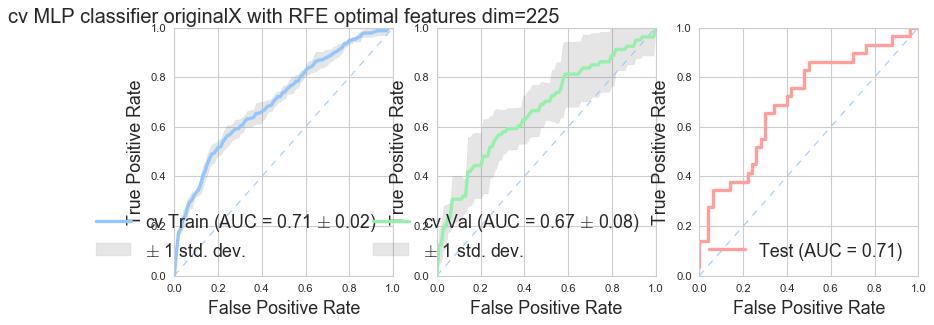

In [6]:
sns.set_style("whitegrid")
sns.set_color_codes("pastel")

figROCs = plt.figure(figsize=(12,4)) 
# plot for cv Train
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.9)
# plot mean and +- 1 -std as fill area
mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_OrigX, mean_tpr_train)
std_auc_train = np.std(auc_train)
axaroc_train.plot(mean_fpr_OrigX, mean_tpr_train, color='b',
            label=r'cv Train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),lw=3, alpha=1)     
std_tpr = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(mean_tpr_train + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_train - std_tpr, 0)
axaroc_train.fill_between(mean_fpr_OrigX, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('cv MLP classifier originalX with RFE optimal features dim={}'.format(X.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
   
# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.9)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_OrigX, mean_tpr_val)
std_auc_val = np.std(auc_val)
axaroc_val.plot(mean_fpr_OrigX, mean_tpr_val, color='g',
            label=r'cv Val (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),lw=3, alpha=1)     
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr, 0)
axaroc_val.fill_between(mean_fpr_OrigX, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)

################
# plot AUC on heldout set
################
MLP_heldout_iter = mx.io.NDArrayIter(X_val, None, batch_size)   
probas_heldout = mlp_model.predict(MLP_heldout_iter)
   
# plot for cv val
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.9)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_val, probas_heldout.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'Test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
plt.show()

pred_test = pd.DataFrame({"labels":y_val,
                          "probC":probas_heldout.asnumpy()[:,1],
                          "probNC":probas_heldout.asnumpy()[:,0]})

In [7]:
pooled_pred_val

,labels,probC,probNC
0,0,0.284305,0.715696
1,0,0.284149,0.715851
2,1,0.286828,0.713172
3,1,0.284194,0.715806
4,0,0.285848,0.714152
5,1,0.284129,0.715871
6,0,0.283530,0.716470
7,0,0.283640,0.716360
8,0,0.283525,0.716475
9,0,0.284036,0.715964


In [8]:
################
# save pooled model probabilties
pooled_pred_train.to_csv('datasets/exp1b_pooled_pred_train.csv', header=True, index=False)
pooled_pred_val.to_csv('datasets/exp1b_pooled_pred_val.csv', header=True, index=False)
pred_test.to_csv('datasets/exp1b_pred_test.csv', header=True, index=False)